In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras import Input, Model, layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import (
    LSTM,
    Activation,
    BatchNormalization,
    Bidirectional,
    Conv1D,
    Dense,
    Dropout,
    GlobalAveragePooling1D,
    LayerNormalization,
    MaxPooling1D,
    MultiHeadAttention,
)
from tensorflow.keras.metrics import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2


In [50]:
# Подготовка данных для модели
y_labels = pd.read_csv('y_labels_100thsnd_withoutscaler.csv')

cnn_arrays = np.load('shuffled_combined_100thsnd_withoutscaler.npz')
X_ts = cnn_arrays['X']
ids_ts = cnn_arrays['ids']

In [51]:
# Фильтруем строки с нужными подтипами
selected_subtypes = ['RRAB', 'BY', 'DCEP', 'DSCT', 'EA', 'UG', 'EW', \
                     'M', 'SR', 'TTS']

filtered_y = y_labels[y_labels['variability_type'].isin(selected_subtypes)]
mask = np.isin(ids_ts, filtered_y['asas_sn_id'].values)
X_ts = X_ts[mask]
ids_ts = ids_ts[mask]
filtered_y = filtered_y[filtered_y['asas_sn_id'].isin(ids_ts)]


In [52]:
# Стратифицированное разделение с сохранением индексов для подклассов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    filtered_y['variability_type'].values,
    ids_ts,
    test_size=0.2,
    stratify=filtered_y['variability_type'],
    random_state=42
)

In [34]:
# Стратифицированное разделение с сохранением индексов для основных классов
X_train, X_val, y_train, y_val, idx_train, idx_val = train_test_split(
    X_ts,
    y_labels['main_class'].values,
    ids_ts,
    test_size=0.2,
    stratify=y_labels['main_class'],
    random_state=42
)

In [ ]:
# Кодирование целевых переменных для подклассов
ohe_main = OneHotEncoder(sparse_output=False)
y_train_onehot = ohe_main.fit_transform(pd.DataFrame(y_train, columns=['variability_type']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['variability_type']))

In [ ]:
# Кодирование целевых переменных для основных классов
ohe_main = OneHotEncoder(sparse_output=False)
y_train_onehot = ohe_main.fit_transform(pd.DataFrame(y_train, columns=['main_class']))
y_val_onehot = ohe_main.transform(pd.DataFrame(y_val, columns=['main_class']))

In [54]:
# Вычисление весов классов для подклассов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(filtered_y['variability_type']),
    y=filtered_y['variability_type']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 1.5618289085545722,
 1: 5.2946,
 2: 2.6526052104208415,
 3: 0.8825804300716786,
 4: 0.529830881617132,
 5: 1.32365,
 6: 0.529777866720032,
 7: 0.5296188856656997,
 8: 5.018578199052133,
 9: 0.9588192683810214}

In [55]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['BY' 2712]
 ['DCEP' 800]
 ['DSCT' 1597]
 ['EA' 4799]
 ['EW' 7994]
 ['M' 3200]
 ['RRAB' 7995]
 ['SR' 7997]
 ['TTS' 844]
 ['UG' 4418]]


In [37]:
# Вычисление весов классов для основных классов
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_labels['main_class']),
    y=y_labels['main_class']
)

# Преобразование в словарь
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
class_weight_dict

{0: 0.7715051266478511,
 1: 5.622285863056495,
 2: 0.4320595414349166,
 3: 1.0884677419354838,
 4: 3.4158810503005377}

In [38]:
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)).T)

[['ECLIPSING' 22393]
 ['ERUPTIVE' 3073]
 ['PULSATING' 39985]
 ['ROTATING' 15872]
 ['cataclysmic' 5057]]


In [56]:
def scale_dataset(data):
    """Масштабируем данные с сохранением паддинга для каждого образца отдельно"""
    scaled_data = np.empty_like(data)
    
    for i in range(data.shape[0]):
        # Копируем признаки
        mag = data[i, :, 0].copy()
        mag_err = data[i, :, 1].copy()
        mjd = data[i, :, 2].copy()
        
        # Определяем границу паддинга по MJD
        non_zero_mask = mjd != 0.0
        valid_length = np.sum(non_zero_mask)
        
        if valid_length > 0:
            # Масштабируем каждый признак отдельно
            for ch, feature in enumerate([mag, mag_err, mjd]):
                scaler = StandardScaler()
                scaled_part = scaler.fit_transform(feature[:valid_length].reshape(-1, 1)).flatten()
                feature[:valid_length] = scaled_part
        
        # Сохраняем масштабированные данные
        scaled_data[i, :, 0] = mag
        scaled_data[i, :, 1] = mag_err
        scaled_data[i, :, 2] = mjd
    
    return scaled_data

# Применяем масштабирование
X_train_scaled = scale_dataset(X_train)
X_val_scaled = scale_dataset(X_val)

In [15]:
n_samples, timesteps, features = X_train.shape

In [57]:
# Callbacks
from tensorflow.keras.callbacks import ModelCheckpoint
# Коллбэк для сохранения F1
checkpoint_f1 = ModelCheckpoint(
    filepath='/content/drive/MyDrive/prsubtypesbest_f1.keras',  
    monitor='val_f1_score',
    mode='max',
    save_best_only=True,
    verbose=1
)

# Коллбэк для сохранения val_loss
checkpoint_loss = ModelCheckpoint(
    filepath='/content/drive/MyDrive/prsubtypesbest_loss.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    TensorBoard(log_dir='./logs'),
    checkpoint_f1,
    checkpoint_loss
]

In [5]:
class PrototypeLayer(layers.Layer):
    def __init__(self, num_prototypes, embedding_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_prototypes = num_prototypes
        self.embedding_dim = embedding_dim

    def build(self, input_shape):
        self.prototypes = self.add_weight(
            name="prototypes",
            shape=(self.num_prototypes, self.embedding_dim),
            initializer="glorot_uniform",
            trainable=True
        )

    def call(self, inputs):
        # Вычисление евклидового расстояния
        expanded_inputs = tf.expand_dims(inputs, 1)
        expanded_prototypes = tf.expand_dims(self.prototypes, 0)
        distances = tf.reduce_sum(
            tf.square(expanded_inputs - expanded_prototypes),
            axis=-1
        )
        return -distances  # отриц расстояние = logits

def build_protonet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Получение фичей
    x = Conv1D(128, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)

    x = Conv1D(256, 7, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)

    residual = x
    x = MultiHeadAttention(num_heads=8, key_dim=32)(x, x)
    x = LayerNormalization(epsilon=1e-6)(x + residual)

    x = Bidirectional(LSTM(64, return_sequences=True))(x)
    x = GlobalAveragePooling1D()(x)

    # Проекция эмбеддингов
    embeddings = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    embeddings = Dropout(0.5)(embeddings)

    # Сравнение прототипов
    logits = PrototypeLayer(num_prototypes=num_classes,
                           embedding_dim=512)(embeddings)

    return Model(inputs=inputs, outputs=logits)

In [59]:
# Компиляция модели
model = build_protonet(
    input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]),
    num_classes=len(ohe_main.categories_[0])
)

model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[F1Score(average='macro')]
)

Обучение подтипов

In [ ]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_onehot,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.3491 - loss: 2.4361
Epoch 1: val_f1_score improved from -inf to 0.46385, saving model to /content/drive/MyDrive/prsubtypesbest_f1.keras

Epoch 1: val_loss improved from inf to 1.59778, saving model to /content/drive/MyDrive/prsubtypesbest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 422s 1s/step - f1_score: 0.3494 - loss: 2.4342 - val_f1_score: 0.4638 - val_loss: 1.5978
Epoch 2/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5387 - loss: 1.2597
Epoch 2: val_f1_score improved from 0.46385 to 0.57065, saving model to /content/drive/MyDrive/prsubtypesbest_f1.keras

Epoch 2: val_loss improved from 1.59778 to 1.19789, saving model to /content/drive/MyDrive/prsubtypesbest_loss.keras
331/331 ━━━━━━━━━━━━━━━━━━━━ 404s 1s/step - f1_score: 0.5387 - loss: 1.2596 - val_f1_score: 0.5707 - val_loss: 1.1979
Epoch 3/50
331/331 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5710 - loss: 1.1695
Epoch 3: val_f1_score improved from 0.5706

In [61]:
# индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 19
Train F1: 0.7062
Train loss: 0.8833
Validation F1: 0.6685
Validation Loss: 0.9909


331/331 ━━━━━━━━━━━━━━━━━━━━ 37s 111ms/step


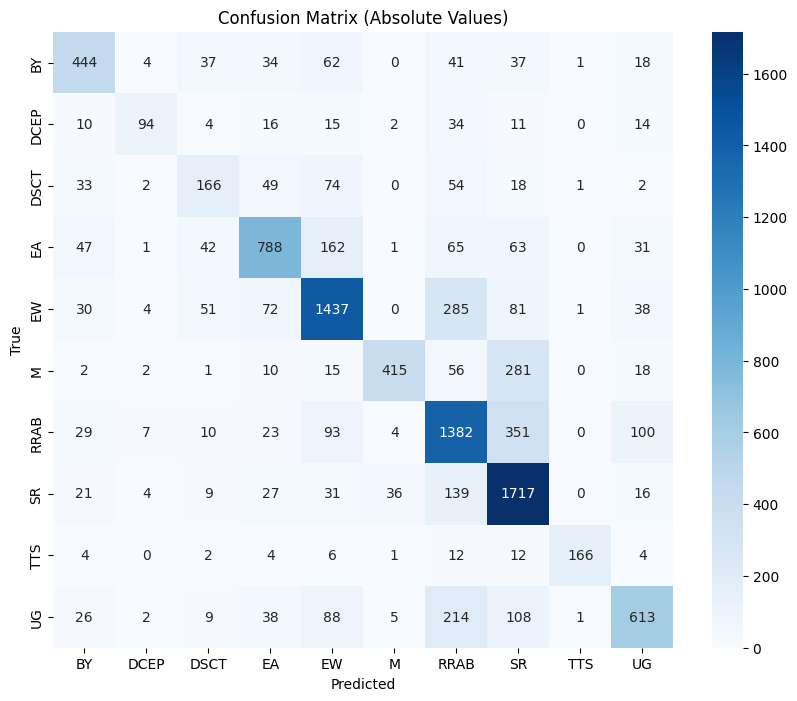

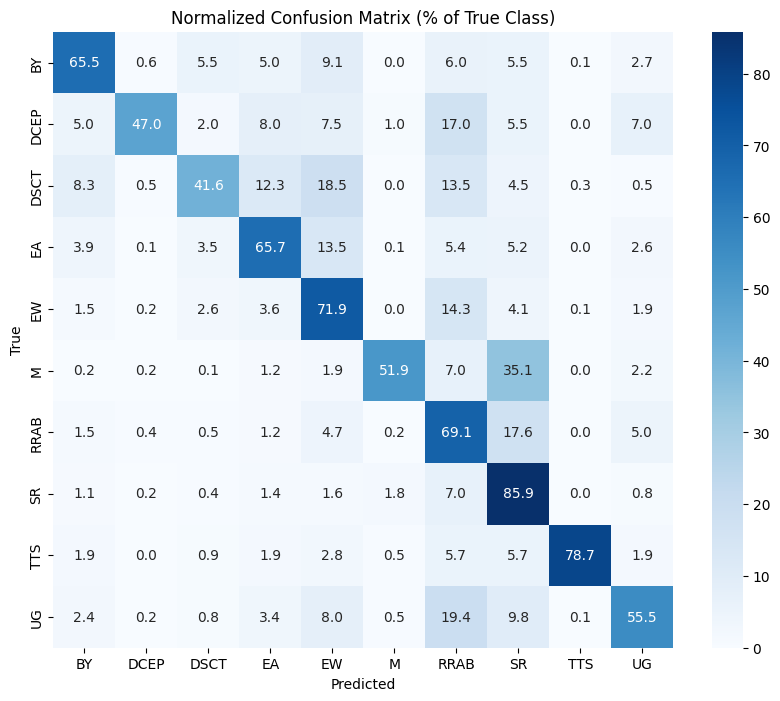

In [62]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# Создание confusion matrix с абсолютными значениями
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Визуализация с абсолютными значениями
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Values)')
plt.show()

# Визуализация с нормализацией по строкам (в процентах)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (% of True Class)")
plt.show()

In [63]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

          BY     0.6873    0.6549    0.6707       678
        DCEP     0.7833    0.4700    0.5875       200
        DSCT     0.5015    0.4160    0.4548       399
          EA     0.7427    0.6567    0.6970      1200
          EW     0.7247    0.7189    0.7217      1999
           M     0.8944    0.5188    0.6566       800
        RRAB     0.6056    0.6913    0.6456      1999
          SR     0.6409    0.8585    0.7339      2000
         TTS     0.9765    0.7867    0.8714       211
          UG     0.7178    0.5553    0.6261      1104

    accuracy                         0.6820     10590
   macro avg     0.7275    0.6327    0.6666     10590
weighted avg     0.6958    0.6820    0.6791     10590



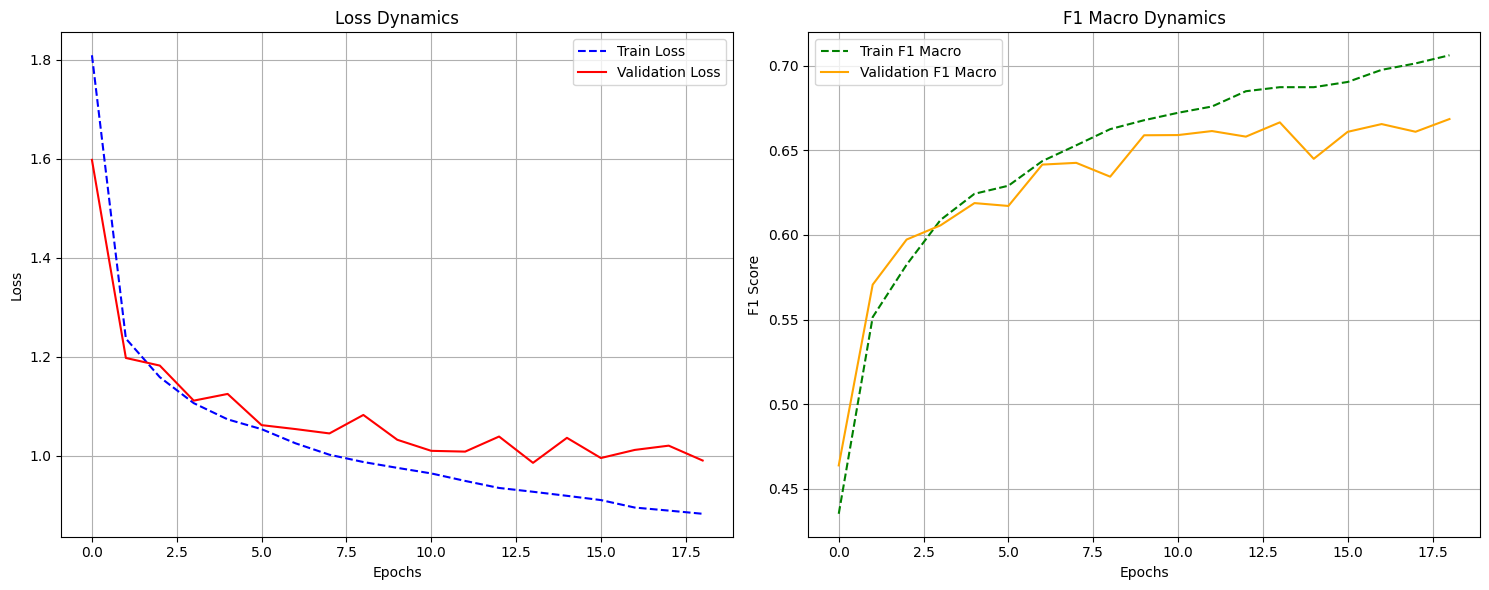

In [64]:
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Обучение основных классов

In [ ]:
# Обучение модели
history = model.fit(
    X_train_scaled,
    y_train_onehot,
    epochs=50,
    batch_size=128,
    validation_data=(X_val_scaled, y_val_onehot),
    callbacks=callbacks
)

Epoch 1/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.3656 - loss: 1.6310
Epoch 1: val_f1_score improved from -inf to 0.48787, saving model to /content/drive/MyDrive/prbest_f1.keras

Epoch 1: val_loss improved from inf to 1.01594, saving model to /content/drive/MyDrive/prbest_loss.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 789s 1s/step - f1_score: 0.3657 - loss: 1.6304 - val_f1_score: 0.4879 - val_loss: 1.0159
Epoch 2/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5082 - loss: 0.9721
Epoch 2: val_f1_score improved from 0.48787 to 0.50983, saving model to /content/drive/MyDrive/prbest_f1.keras

Epoch 2: val_loss improved from 1.01594 to 0.96233, saving model to /content/drive/MyDrive/prbest_loss.keras
675/675 ━━━━━━━━━━━━━━━━━━━━ 797s 1s/step - f1_score: 0.5082 - loss: 0.9721 - val_f1_score: 0.5098 - val_loss: 0.9623
Epoch 3/50
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - f1_score: 0.5367 - loss: 0.9305
Epoch 3: val_f1_score improved from 0.50983 to 0.54265, saving model to /c

In [46]:
# индекс эпохи с max val_f1
best_epoch = np.argmax(history.history['val_f1_score'])

# Метрики лучшей эпохи
best_metrics = {
    'epoch': best_epoch + 1,
    'train_loss': history.history['loss'][best_epoch],
    'val_loss': history.history['val_loss'][best_epoch],
    'train_f1': history.history['f1_score'][best_epoch],
    'val_f1': history.history['val_f1_score'][best_epoch]
}

print(f"Лучшая эпоха: {best_epoch + 1}")
print(f"Train F1: {best_metrics['train_f1']:.4f}")
print(f"Train loss: {best_metrics['train_loss']:.4f}")
print(f"Validation F1: {best_metrics['val_f1']:.4f}")
print(f"Validation Loss: {best_metrics['val_loss']:.4f}")

Лучшая эпоха: 17
Train F1: 0.6178
Train loss: 0.8124
Validation F1: 0.6023
Validation Loss: 0.8548


675/675 ━━━━━━━━━━━━━━━━━━━━ 66s 96ms/step


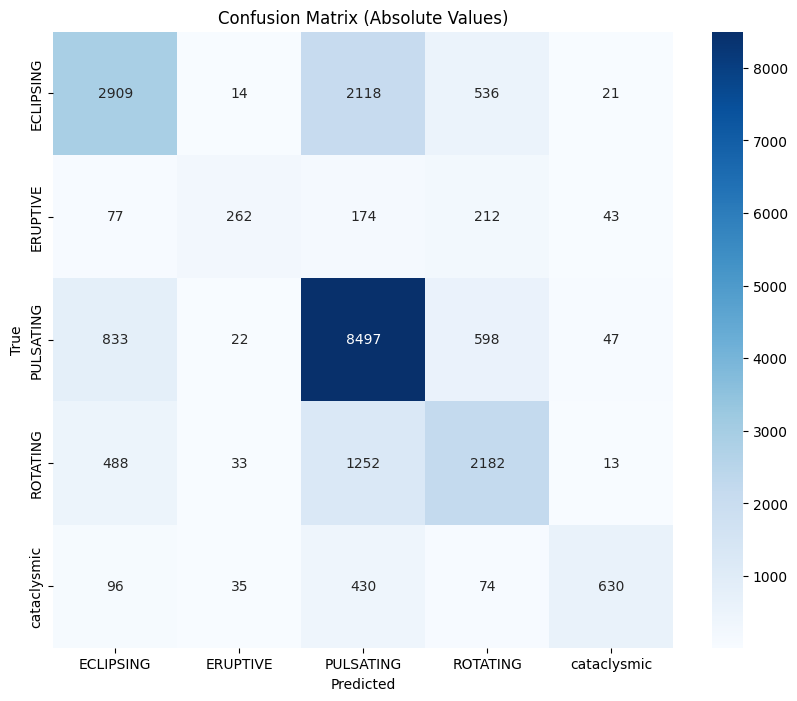

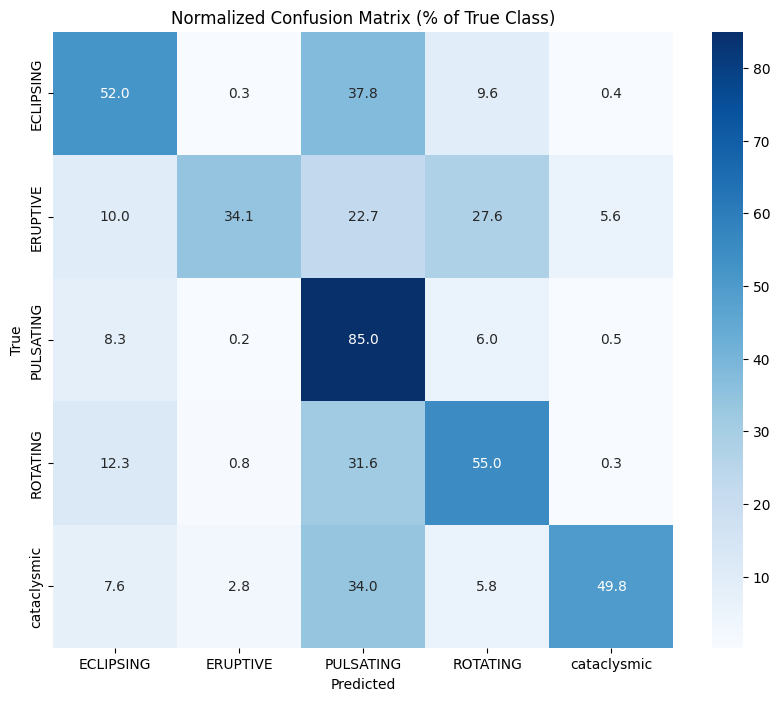

In [47]:
# Получение предсказаний
y_pred = model.predict(X_val_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Преобразование one-hot encoded истинных меток
y_true_classes = np.argmax(y_val_onehot, axis=1)

# Создание confusion matrix с абсолютными значениями
cm = confusion_matrix(y_true_classes, y_pred_classes)

#Визуализация с абсолютными значениями
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Absolute Values)')
plt.show()

# Визуализация с нормализацией по строкам (в процентах)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    cm_percent,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=ohe_main.categories_[0],
    yticklabels=ohe_main.categories_[0]
)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (% of True Class)")
plt.show()

In [48]:
# Генерация отчета
class_names = ohe_main.categories_[0]  
report = classification_report(
    y_true_classes,
    y_pred_classes,
    target_names=class_names,
    digits=4
)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

   ECLIPSING     0.6607    0.5196    0.5817      5598
    ERUPTIVE     0.7158    0.3411    0.4621       768
   PULSATING     0.6813    0.8500    0.7564      9997
    ROTATING     0.6058    0.5499    0.5765      3968
 cataclysmic     0.8355    0.4980    0.6241      1265

    accuracy                         0.6705     21596
   macro avg     0.6998    0.5517    0.6001     21596
weighted avg     0.6724    0.6705    0.6598     21596



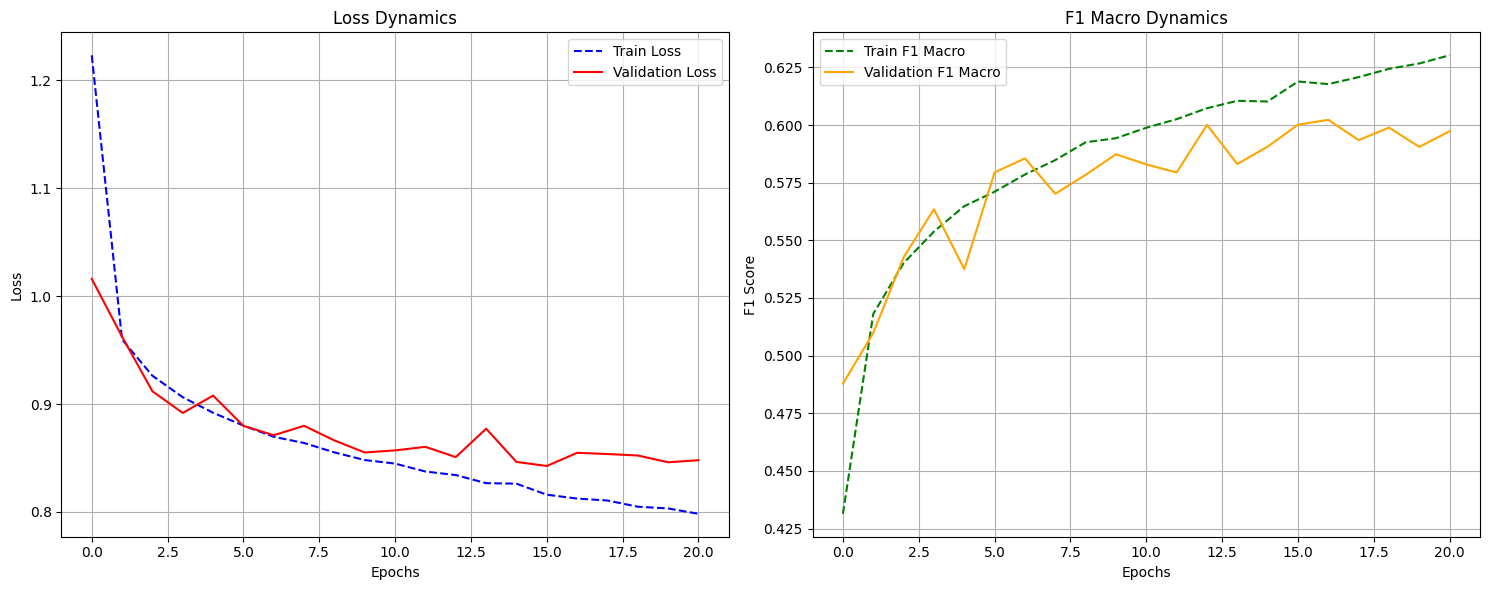

In [49]:
plt.figure(figsize=(15, 6))

# График для Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue', linestyle='--')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red', linestyle='-')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# График для F1 Macro
plt.subplot(1, 2, 2)
plt.plot(history.history['f1_score'], label='Train F1 Macro', color='green', linestyle='--')
plt.plot(history.history['val_f1_score'], label='Validation F1 Macro', color='orange', linestyle='-')
plt.title('F1 Macro Dynamics')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()